In [1]:
# Set up
import pandas as pd
import zipfile
from zipfile import ZipFile

file_name = "playground-series-s4e7.zip"
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file 
    zip.printdir()
df_zip = zipfile.ZipFile(file_name)
# train = pd.read_csv(df_zip.open('train.csv'))

# import sample
import random

n = len(train)  # Calculate number of rows in file
s = n // 10  # sample size of 10%
skip = sorted(random.sample(range(1, n + 1), n - s))
train_sample = pd.read_csv(df_zip.open('train.csv'), skiprows=skip)
train_sample

File Name                                             Modified             Size
sample_submission.csv                          2024-06-24 13:46:18     99708270
test.csv                                       2024-06-24 13:46:24    433918183
train.csv                                      2024-06-24 13:46:48    662779095


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,9,Female,66,1,11.0,0,1-2 Year,Yes,2630.0,26.0,125,0
1,16,Male,34,1,37.0,0,1-2 Year,Yes,30226.0,26.0,240,0
2,21,Male,34,1,46.0,1,< 1 Year,No,29698.0,152.0,185,0
3,24,Female,42,1,11.0,0,1-2 Year,Yes,21473.0,26.0,152,0
4,43,Male,79,1,48.0,1,1-2 Year,No,2630.0,15.0,267,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1150474,11504762,Male,55,1,28.0,1,1-2 Year,No,56871.0,26.0,33,0
1150475,11504779,Female,58,1,28.0,1,1-2 Year,No,52623.0,25.0,117,0
1150476,11504790,Female,21,1,36.0,1,< 1 Year,No,38097.0,152.0,275,0
1150477,11504792,Male,34,1,28.0,1,1-2 Year,No,29974.0,154.0,201,0


# reduce memory

In [2]:
train_sample = train_sample.drop('id', axis = 1)

categorical = ["Region_Code", "Policy_Sales_Channel", "Gender", "Vehicle_Damage", "Vehicle_Age"]
# convert obj to cat
train_sample[["Region_Code", "Policy_Sales_Channel"]] = train_sample[["Region_Code", "Policy_Sales_Channel"]].astype('int64')
train_sample[categorical] = train_sample[categorical].astype("category")

# train_sample sample
train_sample[["Region_Code", "Policy_Sales_Channel"]] = train_sample[["Region_Code", "Policy_Sales_Channel"]].astype('int64')
train_sample[categorical] = train_sample[categorical].astype("category")

# convert numerics into int 32 

import numpy as np
# integer
d = dict.fromkeys(train_sample.select_dtypes(np.int64).columns, np.int64)
train_sample = train_sample.astype(d)

# float
d2 = dict.fromkeys(train_sample.select_dtypes(np.float64).columns, np.int64)
train_sample = train_sample.astype(d2)


# Split

In [5]:
from sklearn.model_selection import train_test_split
Xs = train_sample.drop("Response", axis = 1)
ys = train_sample["Response"]
Xs_train, Xs_val, ys_train, ys_val = train_test_split(Xs,ys,
                                                    test_size = 0.2,
                                                    random_state = 42,
                                                    stratify = ys)

# encoders setup

In [ ]:

from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from category_encoders import BinaryEncoder

unique_values = Xs_train.select_dtypes(include = ['object', 'category']).nunique()

binary_cat = unique_values.index[unique_values == 2].tolist()
ordinal_cat = ["Vehicle_Age"]
target_cat = unique_values.index[unique_values > 20].tolist()
categorical = Xs_train.select_dtypes(include = ['object', 'category']).columns.values.tolist()
categorical.remove("Vehicle_Age")
nominal_cat = list(set(categorical).difference(binary_cat))

vehicle_age_categories = ['< 1 Year', '1-2 Year', '> 2 Years']

# numerical transformer
num_col = ['Age','Annual_Premium','Vintage']


# Encoders

In [33]:

# ordinal encoder
ordinal = Pipeline(steps=[
    ("ordinal", OrdinalEncoder(categories=[['< 1 Year', '1-2 Year', '> 2 Years']])),
])
# target encoder
target = Pipeline(steps=[
    ("target", TargetEncoder()),
])

# ohe encoder
ohe  = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown= 'ignore')),
])

# dummy encoder
binary = Pipeline(steps=[
    ("dummy",BinaryEncoder()),
])

num_pipe = Pipeline(steps=[
    ("standardize", StandardScaler()) # standardize
])




In [ ]:
pipe = ColumnTransformer(
    transformers=[
        ("ord", ordinal, ordinal_cat),
        ("dummy", binary, binary_cat),
        ("num", num_pipe, num_col),
        ("target",target, nominal_cat)
    ],
    remainder = "passthrough"
    
)

In [46]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(verbose = 2, n_jobs = -1, random_state = 42, max_depth = 50) 

pipeline = Pipeline(steps=[
          ('column_tran',pipe),
          ('model',rf)
     ])

In [47]:
pipeline.fit(Xs_train, ys_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.6s


building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   51.7s finished
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('column_tran',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(categories=[['< '
                                                                                               '1 '
                                                                                               'Year',
                                                                                               '1-2 '
                                                                                               'Year',
                                                                                               '> '
                                                                                               '2 '
                                                                                               'Years']]))]),
                                                  ['Vehicle_Age']),
                                                 ('dummy',
                                                  Pipeline(steps=[('dummy',
                                                                   BinaryEncoder())]),
                                                  ['Gender', 'Vehicle_Damage']),
                                                 ('num',
                                                  Pipeline(steps=[('standardize',
                                                                   StandardScaler())]),
                                                  ['Age', 'Annual_Premium',
                                                   'Vintage']),
                                                 ('ohe',
                                                  Pipeline(steps=[('target',
                                                                   TargetEncoder())]),
                                                  ['Region_Code',
                                                   'Policy_Sales_Channel'])])),
                ('model',
                 RandomForestClassifier(max_depth=50, n_jobs=-1,
                                        random_state=42, verbose=2))])

In [48]:
pred = pipeline.predict(Xs_val)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.3s finished


In [49]:
from sklearn.metrics import confusion_matrix
confusion_matrix(ys_val,pred)

array([[194948,   6869],
       [ 23600,   4679]])

In [50]:
from sklearn.metrics import precision_score,accuracy_score,recall_score,f1_score
accuracy_score(ys_val,pred)

0.8675813573464989

In [51]:
pipeline.get_params()

{'memory': None,
 'steps': [('column_tran',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('ord',
                                    Pipeline(steps=[('ordinal',
                                                     OrdinalEncoder(categories=[['< '
                                                                                 '1 '
                                                                                 'Year',
                                                                                 '1-2 '
                                                                                 'Year',
                                                                                 '> '
                                                                                 '2 '
                                                                                 'Years']]))]),
                                    ['Vehicle_Age']),
                                   ('dummy'

In [52]:
max_depth = list()

for tree in pipeline['model'].estimators_:
    max_depth.append(tree.tree_.max_depth)

print("avg max depth %0.1f" % (sum(max_depth) / len(max_depth)))


avg max depth 50.0


<Axes: ylabel='Count'>

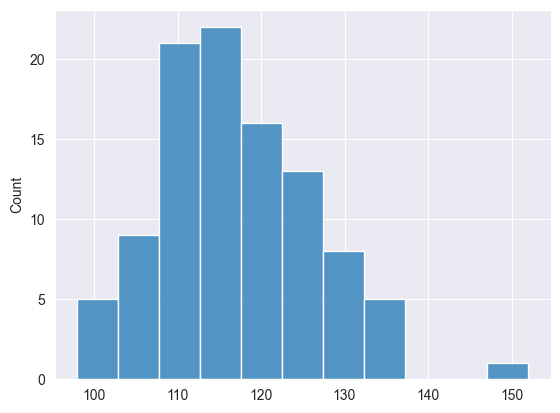

In [37]:
import seaborn as sns
sns.histplot(data = max_depth)